In [1]:
#%% this script is a development of using CNN in the stock prediction using CNN
#the reference project is from 
#https://www.kaggle.com/nisasoylu/stock-market-prediction-using-cnn

#%% import library
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.preprocessing import scale
from tensorflow.keras import backend as K, callbacks
from sklearn.metrics import accuracy_score as accuracy, f1_score, mean_absolute_error as mae
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPool2D
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt
import os



Using TensorFlow backend.


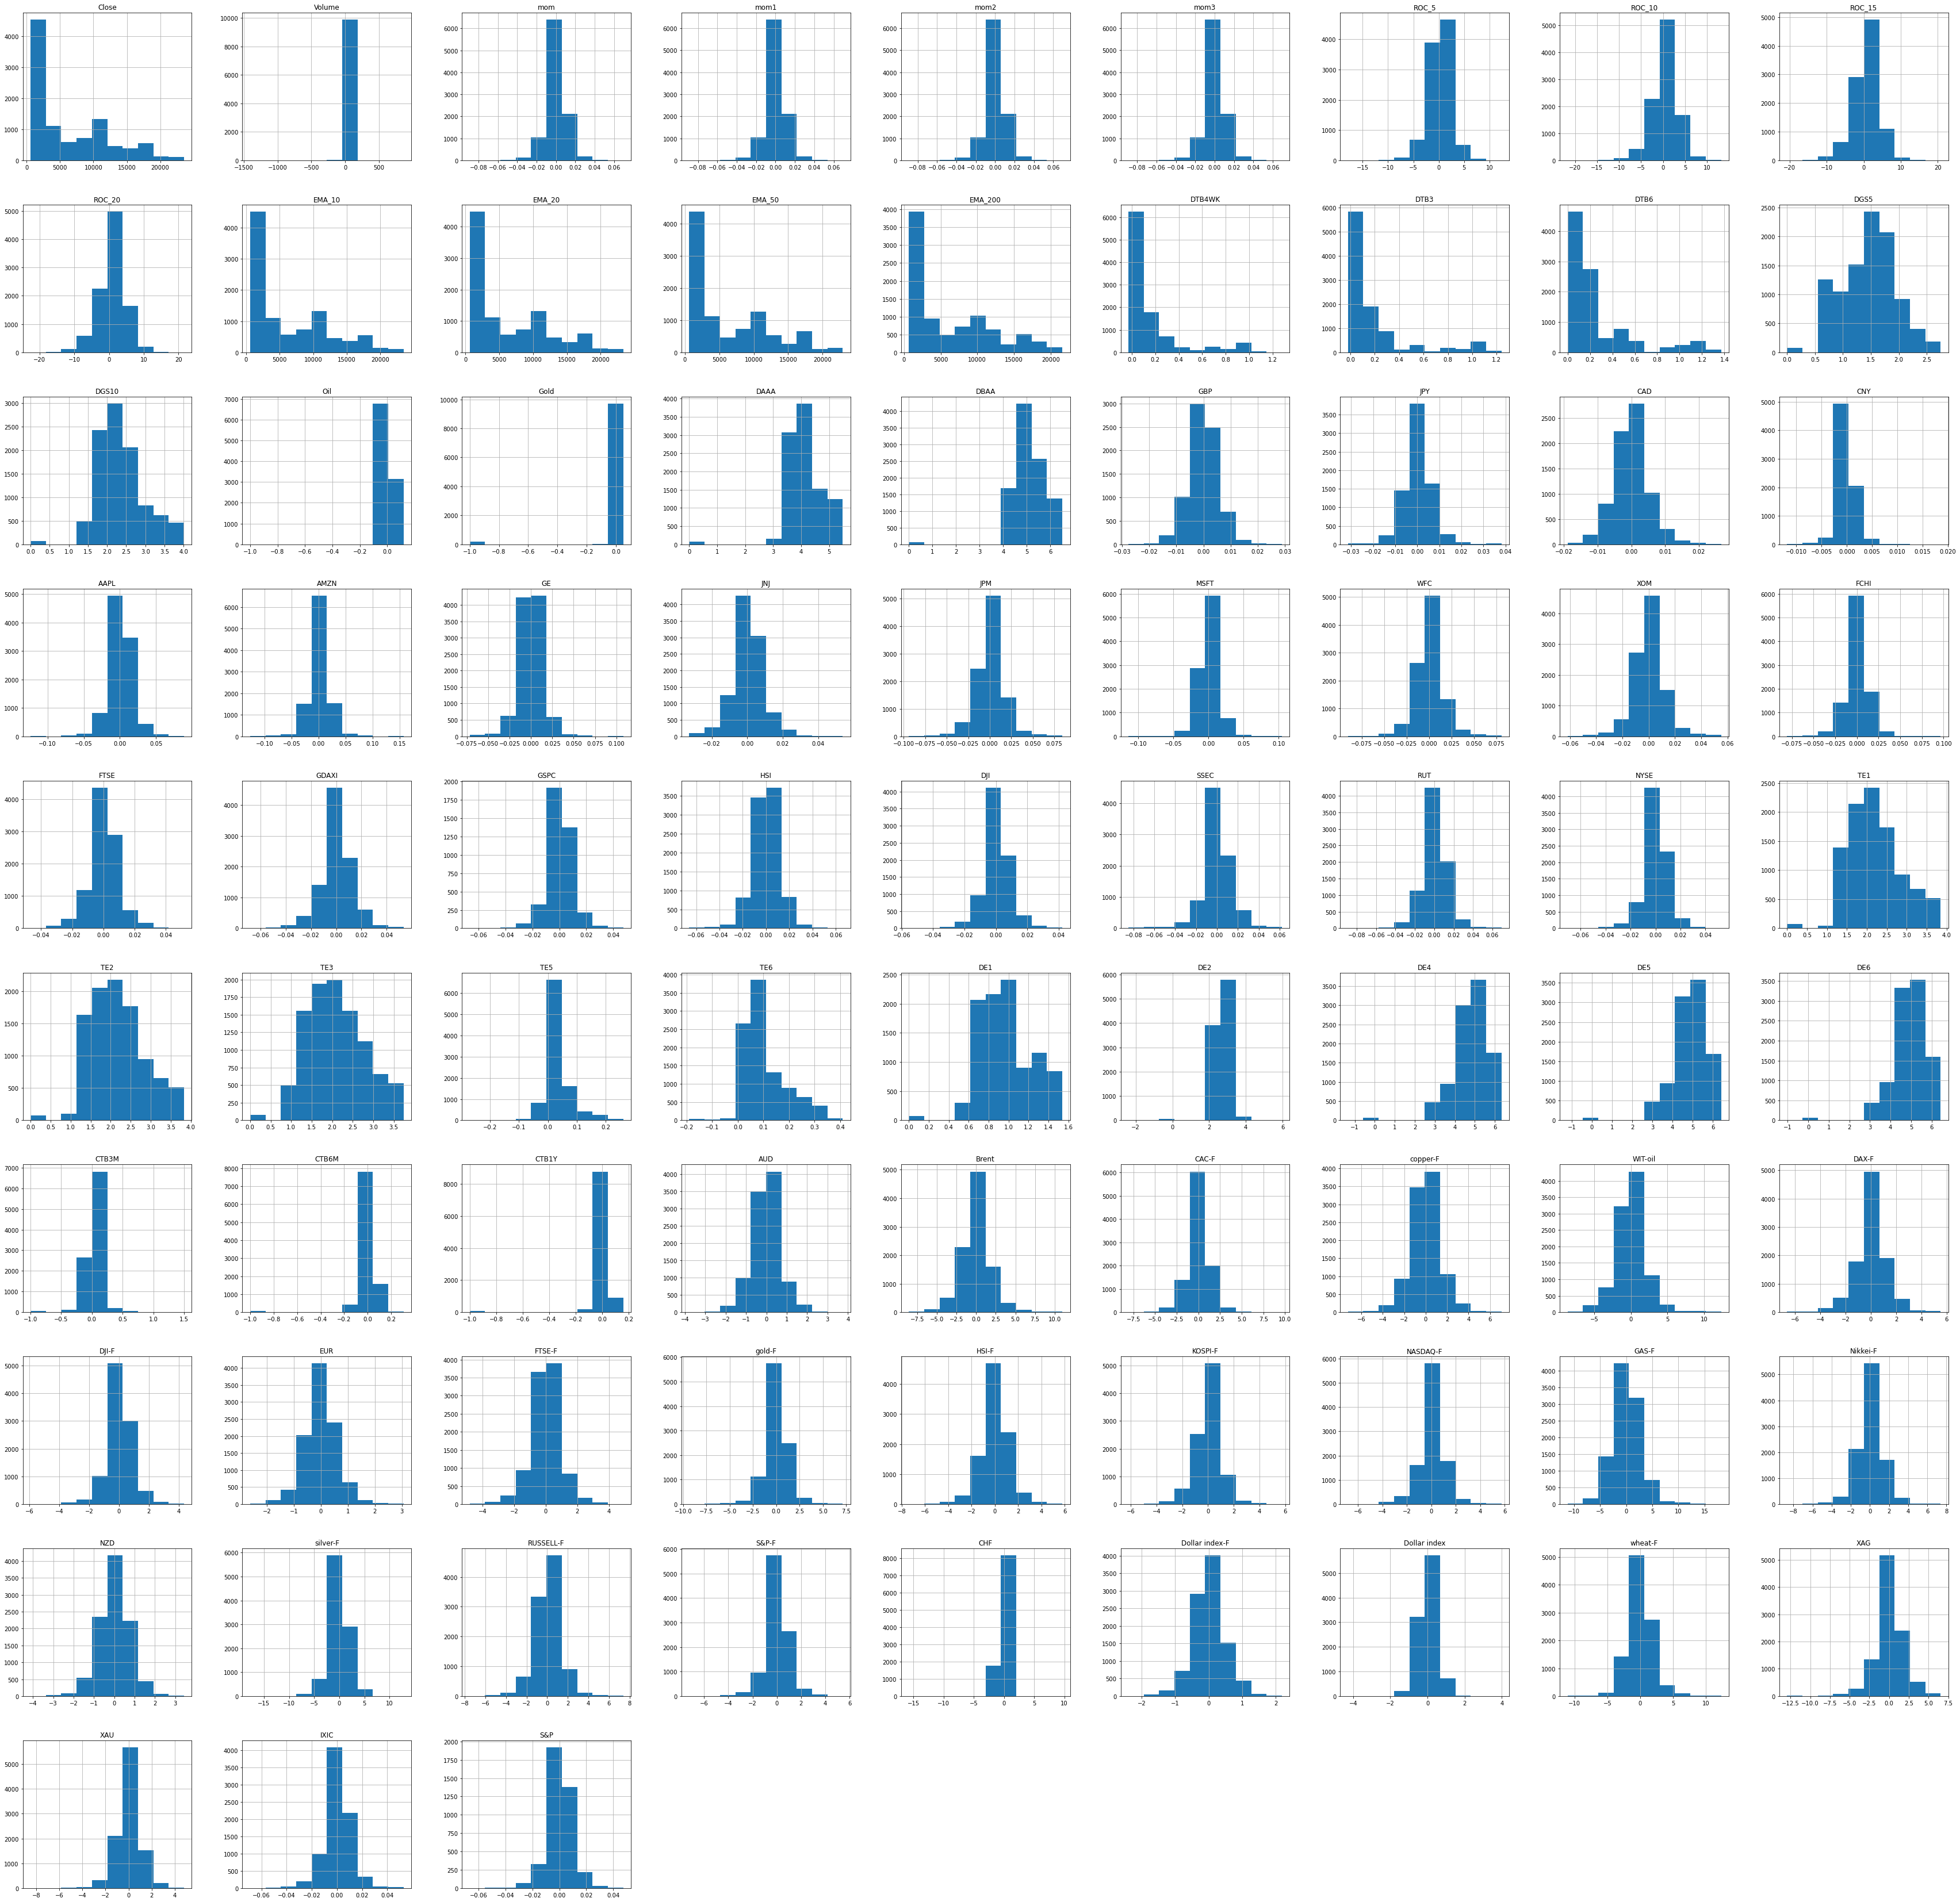

In [2]:
#%% read data
rawdata_1 = pd.read_csv("./input/Processed_NASDAQ.csv", parse_dates=['Date'])
rawdata_2 = pd.read_csv("./input/Processed_NYSE.csv", parse_dates=['Date'])
rawdata_3 = pd.read_csv("./input/Processed_SP.csv", parse_dates=['Date'])
rawdata_4 = pd.read_csv("./input/Processed_DJI.csv", parse_dates=['Date'])
rawdata_5 = pd.read_csv("./input/Processed_RUSSELL.csv", parse_dates=['Date'])
#set index
rawdata_1.index = rawdata_1['Date']
rawdata_2.index = rawdata_2['Date']
rawdata_3.index = rawdata_3['Date']
rawdata_4.index = rawdata_4['Date']
rawdata_5.index = rawdata_5['Date']
#create whole dataset
dataset = rawdata_1.append(rawdata_2, ignore_index=True)
dataset = dataset.append(rawdata_3, ignore_index=True)
dataset = dataset.append(rawdata_4, ignore_index=True)
dataset = dataset.append(rawdata_5, ignore_index=True)
#dataset
#evaluate nan value
dataset.isnull().sum()
#data visualisation with the size of 60*60
dataset.hist(figsize=(60,60))
#plt.show()
#%% CNN def 
#below parameters can be changed for sensentivity test
predict_index = 'NYA' ## can be either of RUT (scenario 4), S&P (scenario 1), NYA (scenario 3), NASDAQ (scenario 2), DJI (baseline)
stock_no = 5
order_stocks = []
predict_day = 1 # baseline 1, scenario 1: 7, scenario 2: 30
Moving_average=200 # baseline: 200, scenario 1: 180, scenario 2: 220



In [3]:
#%% defs
def prepare_for_CNN(): # this is used to split the dataset to train and test
    global stock_no
    global samples_in_each_stock
    global number_feature
    #global predict_index
    global order_stocks
    t_train = np.empty((0,82)) # total training dataset
    t_train_tgt = np.empty((0)) # total training target data
    t_test = np.empty((0,82)) # total testing dataset
    t_test_tgt = np.empty((0)) # total testing target data
    
    for data in [rawdata_4, rawdata_1, rawdata_2, rawdata_5, rawdata_3]:
        df_name = data['Name'][0]
        order_stocks.append(df_name)
        del data['Name']

        target = (data['Close'][predict_day:] / data['Close'][:-predict_day].values).astype(int)

        data = data[:-predict_day]
        target.index = data.index
        # Moving Average is a variable in this development tool
        data = data[Moving_average:]
        data = data.fillna(0)
        data['target'] = target
        target = data['target']
        del data['target']
        del data['Date']

        number_feature = data.shape[1]
        samples_in_each_stock = data.shape[0]
        # data before 2016-04-21 as the training set, after 2016-04-21 as testing set
        train_data = data[data.index < '2016-04-21']
        train_data = scale(train_data)

        if df_name == predict_index:
            t_train_tgt = target[target.index < '2016-04-21']
            t_test_tgt = target[target.index >= '2016-04-21']

        data = pd.DataFrame(scale(data.values), columns=data.columns)
        data.index = target.index
        test_data = data[data.index >= '2016-04-21']

        t_train = np.concatenate((t_train, train_data))
        t_test = np.concatenate((t_test, test_data))
        
    train_size = int(t_train.shape[0]/stock_no)
    print("Train size:", train_size)
    test_size = int(t_test.shape[0] / stock_no)
    print("Test size:", test_size)
    
    t_train = t_train.reshape(stock_no, train_size, number_feature)
    t_test = t_test.reshape(stock_no, test_size, number_feature) 
    return t_train, t_test, t_train_tgt, t_test_tgt


In [4]:
def cnn_data_sequence(data, target, seque_len): # this is to get new train and target dataset
    print ('cnn data sequence ...')
    new_train = []
    new_target = []

    for index in range(data.shape[1] - seque_len + 1):
        new_train.append(data[:, index: index + seque_len])
        new_target.append(target[index + seque_len - 1])
    new_train = np.array(new_train)
    new_target = np.array(new_target)
    return new_train, new_target


In [5]:
def f1(y_true, y_pred): #Only computes a batch-wise average of recall
    def recall(y_true, y_pred): #recall of selected relevant items
        posi = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = posi / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred): # precision of selected relevant items
        posi = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        pred_posi = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = posi / (pred_posi + K.epsilon())
        return precision

    prec = precision(y_true, y_pred)
    rec_pos = recall(y_true, y_pred)
    prec_neg = precision((K.ones_like(y_true)-y_true), (K.ones_like(y_pred)-K.clip(y_pred, 0, 1)))
    rec_neg = recall((K.ones_like(y_true)-y_true), (K.ones_like(y_pred)-K.clip(y_pred, 0, 1)))
    f_posit = 2*((prec*rec_pos)/(prec+rec_pos+K.epsilon()))
    f_neg = 2 * ((prec_neg * rec_neg) / (prec_neg + rec_neg + K.epsilon()))
    return (f_posit + f_neg) / 2

In [6]:
def sklearn_acc(model, test_data, test_target): #
    overall_results = model.predict(test_data)
    test_pred = (overall_results > 0.5).astype(int)
    acc_results = [mae(overall_results, test_target), accuracy(test_pred, test_target),
                   f1_score(test_pred, test_target, average='macro')]
    return acc_results

number_filter = [8,8,8]

In [7]:
def CNN(train_data, test_data, train_target, test_target): # core function for prediction
    seq_len = 60
    epoc = 100
    drop = 0.1
    cnn_train_data, cnn_train_target = cnn_data_sequence(train_data, train_target, seq_len)
    cnn_test_data, cnn_test_target = cnn_data_sequence(test_data, test_target, seq_len)
    result = []
    
    for i in range(1,5):
        K.clear_session()
        print ('i: ', i)
        print('fitting model')
        model = Sequential()
        #layer 1
        model.add(Conv2D(number_filter[0], (1, 1), activation='relu', input_shape=(stock_no,seq_len, number_feature), data_format='channels_last'))
        model.add(Dropout(0.1)) # added
        #layer 2
        model.add(BatchNormalization())   # added
        model.add(Conv2D(number_filter[1], (stock_no, 3), activation='relu'))
        model.add(MaxPool2D(pool_size=(1, 2)))
        model.add(Dropout(0.2))   # added
        #layer 3
        model.add(Conv2D(number_filter[2], (1, 3), activation='relu'))
        model.add(MaxPool2D(pool_size=(1, 2)))
        # Flattening Layer:
        model.add(Flatten())
        model.add(Dropout(0.4))  # added
        # Last Layer:
        model.add(Dense(1, activation='softmax')) # baseline sigmoid, scenario 1 relu, senario 2: softmax
        model.compile(optimizer='Adam', loss='mae', metrics=['acc',f1])
        model.fit(cnn_train_data, cnn_train_target, epochs=epoc, batch_size=128, verbose=0, validation_split=0.25) #callbacks=[best_model],
        test_pred = sklearn_acc(model,cnn_test_data, cnn_test_target)
        print (test_pred)
        result.append(test_pred)
        model.summary() # added 
    
    print('summaritive results')
    results = pd.DataFrame(result , columns=['MAE', 'Accuracy', 'F-score'])
    results = results.append([results.mean(), results.max(), results.std()], ignore_index=True)

    #results.to_csv(join(Base_dir, '3D-models/{}/new results.csv'.format(predict_index)), index=False)
    return results

In [8]:
# run the CNN
train_data, test_data, train_target, test_target = prepare_for_CNN()
CNN(train_data, test_data, train_target, test_target)
#%%

Train size: 1386
Test size: 397
cnn data sequence ...
cnn data sequence ...
i:  1
fitting model
[0.46153846153846156, 0.5384615384615384, 0.35000000000000003]
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 5, 60, 8)          664       
_________________________________________________________________
dropout (Dropout)            (None, 5, 60, 8)          0         
_________________________________________________________________
batch_normalization (BatchNo (None, 5, 60, 8)          32        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 1, 58, 8)          968       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 1, 29, 8)          0         
_________________________________________________________________
dropout_1 (Dropout)          

,MAE,Accuracy,F-score
0,0.461538,0.538462,0.35
1,0.461538,0.538462,0.35
2,0.461538,0.538462,0.35
3,0.461538,0.538462,0.35
4,0.461538,0.538462,0.35
5,0.461538,0.538462,0.35
6,0.000000,0.000000,0.00
